In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# Deutsch-Jozsa Algorithm

Deutsch-Jozsa Problem
We are given a hidden Boolean function f, which takes as input a string of bits, and returns either 0 or 1.
The property of the given Boolean function f is that it is guaranteed to either be balanced or constant.
A constant function returns all 0's or all 1's for any input, while a balanced function returns 0's for exactly half of all inputs and 1's for the other half. 
Our task is to determine whether the given function is balanced or constant.

In [33]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [34]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    
    dj_circuit.x(n) # Setting nth qubit to |->
    dj_circuit.h(n)
    
    for qubit in range(n):    # Applying H gates to the n input register qubits
        dj_circuit.h(qubit)
        
    dj_circuit.append(oracle, range(n+1))    # Querying oracle
    
    for qubit in range(n):    # Applying H gates to the n input register qubits again
        dj_circuit.h(qubit)
    
    for i in range(n):        # Measurement
        dj_circuit.measure(i, i)
    
    return dj_circuit

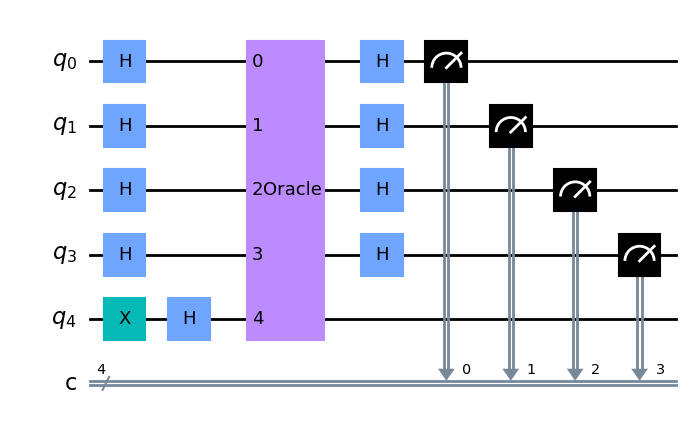

In [35]:
# Balanced function

n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw(output='mpl')

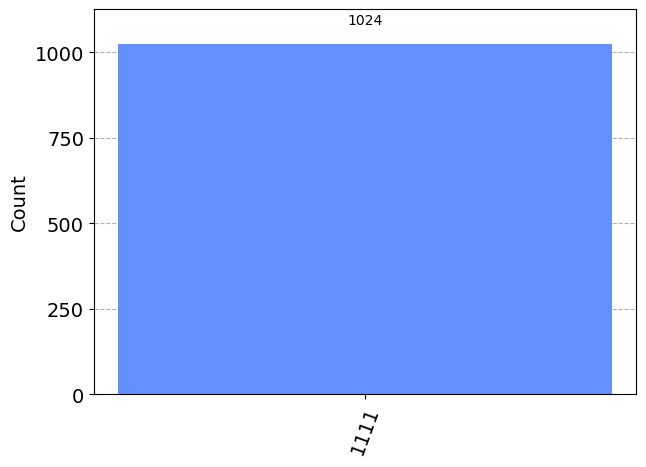

In [36]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

We are getting a probability 0 of measuring '0000' for a balanced function. 

In [37]:
# Constant function

n = 4
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)

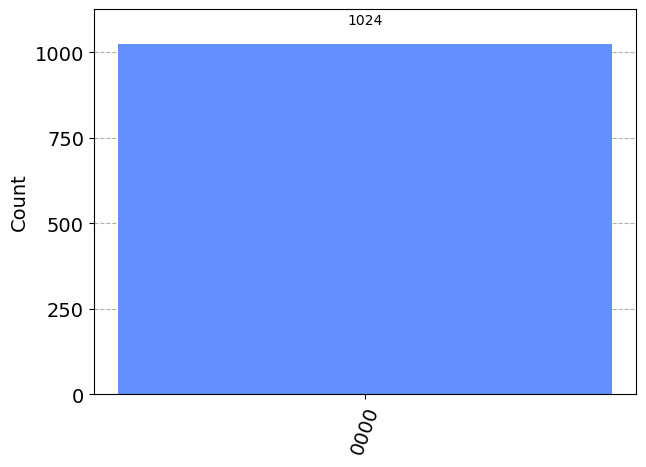

In [38]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

We are getting probability 1 of measuring '0000' for a constant function.

# The Bernstein-Vazirani Problem

We are again given a black-box function f, which takes as input a string of bits (x), and returns either 0 or 1.

Instead of the function being balanced or constant as in the Deutsch-Jozsa problem, now the function is guaranteed to return the bitwise product of the input with some string, s. 
In other words, given an input x, f(x) =s.x (mod 2). We are expected to find s.

In [39]:
n = 3 # number of qubits used to represent s
s = '101'   # the hidden binary string

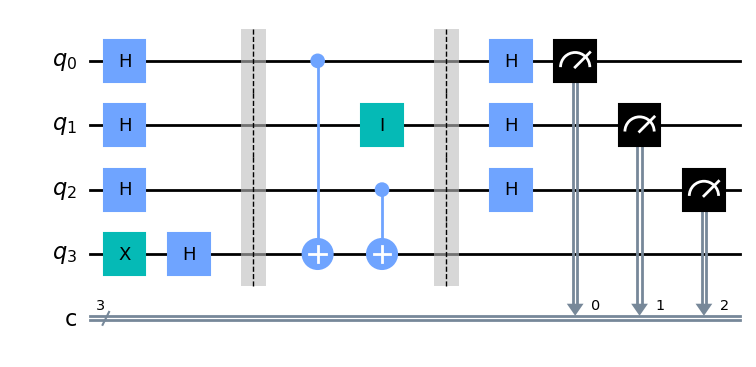

In [40]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.x(n)
bv_circuit.h(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw(output='mpl')

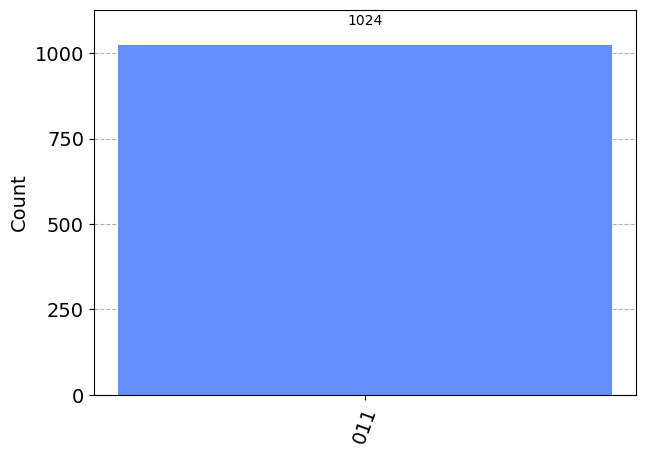

In [31]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
results = aer_sim.run(bv_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

We are getting the string s = '011' as expected.